In [11]:
#Preamble
import tensorflow as tf
#enable Eager execution
tf.enable_eager_execution()

import numpy as np
import matplotlib.pyplot as plt

#Start Interactive Session
sess = tf.InteractiveSession()

def PN_phases(freq,mTot,eta,t_c,phi_c,phase_order):
    
    #constants in equation
    piM = tf.multiply(mTot*4.96e-6,np.pi) # Total mass times pi
    v = tf.pow(tf.multiply(piM,freq),(1/3)) # characteristic velocity of binary'
    
    #v parameters
    v0 = tf.pow(v,-5)
    
    #produce PN coeffiecients
    PN_cnst = tf.add((2*np.pi*t_c*freq),(-phi_c))
    P0 = tf.multiply((3./128),tf.reciprocal(eta))
    
    #Produce full PN terms
    PN0 = tf.multiply(P0,v0)
    
    #phases = PN_cnst + PN0
    phases = tf.add(PN_cnst,PN0)
    
    return phases

def PN_amplitude(freq,ChirpMass,LuminosityDistance):
    #returns the amplitude of the 0PN waveform
    #arguments are chirp mass, luminosity distance and frequencies
                         
    term1 = tf.reciprocal(LuminosityDistance/3e8)# divide by factor of c to convert to units of time
    term2 = tf.multiply(np.sqrt(5/24)*(np.pi**(-2/3)),tf.pow(ChirpMass*4.96e-6,(5/6))) #times by mtsol to get units of time
    term3 = tf.pow(freq,(-7/6))
                         
    return tf.multiply(term1,tf.multiply(term2,term3))

def TaylorFlow(mass1,mass2,frequencies=None,LuminosityDistance=1.,t_c=0,phi_c=0.,f_low=10.,
               df=0.1,f_high=2000.,phase_order=0):
    """
    TaylorFlow Main Function
    
    """
    
    #Define variable and constants in TensorFlow variables and constants   
    #Masses and frequencies are required inputs
    mass1 = tf.constant(mass1,name="mass1",dtype=tf.float32)
    mass2 = tf.constant(mass2,name="mass2",dtype=tf.float32)
    
    #get total mass,chirp mass and symetric mass ratio for use later in function
    M = tf.add(mass1,mass2) # m1 + m2 
    eta = tf.divide(tf.multiply(mass1,mass2),tf.square(M)) # (m1*m2)/(m1+m2)^2
    ChirpMass = tf.multiply(M,tf.pow(eta,(3/5))) #Chirp mass is given by M*(eta^3/5)   
    
    #define frequencies
    f_ISO = 1/(6.**1.5*np.pi*(M)*4.93e-6) #frequency of innermost stable circular orbit (SI units)
    if frequencies == None:
        f = np.arange(1.,f_high,df)
        frequencies = tf.Variable(f,name= "frequencies",dtype= tf.float32)
    else:  
        frequencies = tf.Variable(frequencies,name= "frequencies",dtype= tf.float32)
        
    #other constants                     
    L_D =  tf.constant((3.086e+22*LuminosityDistance),name="LuminosityDistance",dtype=tf.float32) 
    
    #get phases at 0PN order
    phase = PN_phases(frequencies,M,eta,t_c,phi_c,phase_order)
    amp = PN_amplitude(frequencies,ChirpMass,L_D)
    
    #set amplitude to zero where the waveform results are unphysical
    cond1 = frequencies<f_low #below f_low
    ind1 = tf.where(cond1)
    cond2 = frequencies>f_ISO #above fISCO
    ind2 = tf.where(cond2)
    amp = tf.scatter_update(tf.Variable(amp), ind1, tf.constant(0.))
    amp = tf.scatter_update(tf.Variable(amp), ind2, tf.constant(0.))
    
    #Calculte waveform
    iphase = tf.multiply(tf.complex(0.,1.),tf.complex(phase-(np.pi/4),0.))
    waveform = tf.multiply(tf.complex(amp,0.),tf.exp(iphase))
    
    return frequencies,waveform

C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\client\session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


In [44]:
m1 = 1.4
m2 = 1.4
df = 1./1024
tc_ = 0.
phi_ = 0.

freq, waveform  = TaylorFlow(m1, m2, f_low=20., f_high=2000, df=df, t_c=tc_, phi_c = phi_)

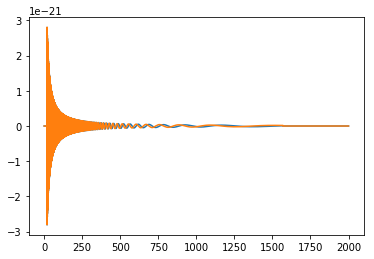

In [48]:
plt.plot(freq.numpy(),np.real(waveform))
plt.plot(freq.numpy(),np.imag(waveform))

In [46]:
np.savetxt('TensorflowFreq.txt',freq.numpy())
np.savetxt('TensorflowWaveform.txt',waveform)